<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Run GriddedCCP

In [1]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [2]:
import neuralproc

In [3]:
import submitit
from train_imgs import main, parse_arguments

log_folder="logs/%j"

In [14]:
def repeat_list(l, n):
    return [i for i in l for _ in range(n)]

class Run:
    def checkpoint(self, args):
        """Resubmits the same callable with the same arguments but makes sure continnue from last chckpnt."""
        args.is_continue_train=True 
        return submitit.utils.DelayedSubmission(self, args)
    
    def __call__(self, args):
        job_env = submitit.core.utils.JobEnvironment()
        args.starting_run = args.starting_run * job_env.num_tasks + job_env.local_rank
        return main(args)

In [54]:
datasets_64 = ["zs-multi-mnist"]

Grided_ccp_kwargs = [(f"GridedCCP_varyingk/k{kernel}", f"--n-blocks 5 --kernel-size {kernel} --init-kernel-size 11 --max-epochs 2")
                     for kernel in [1+2*i for i in range(1,9)]]

args_64_ccp = [parse_arguments("GridedCCP {} --starting-run {} --name {} --chckpnt-dirname results/iclr-rebuttal/ {}".format(d, s, name, other).split())
                for s in range(3)
                for d in datasets_64
                for name,other in Grided_ccp_kwargs]


In [55]:
executor_64_ccp=submitit.SlurmExecutor(folder=log_folder, max_num_timeout=3)
executor_64_ccp.update_parameters(num_gpus=1, 
                                   time=20,#60*24*2,  
                                   cpus_per_task=10, 
                                   mem='32GB',
                                   ntasks_per_node=2,
                                  partition="dev"
                                  )

In [56]:
job_64_ccp = executor_64_ccp.map_array(Run(), args_64_ccp)

In [57]:
############################################################

In [79]:
job_64_ccp

[SlurmJob<job_id=19951207_0, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_1, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_2, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_3, task_id=None, state="TIMEOUT">,
 SlurmJob<job_id=19951207_4, task_id=None, state="TIMEOUT">,
 SlurmJob<job_id=19951207_5, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_6, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_7, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_8, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_9, task_id=None, state="FAILED">,
 SlurmJob<job_id=19951207_10, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_11, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_12, task_id=None, state="COMPLETED">,
 SlurmJob<job_id=19951207_13, task_id=None, state="RUNNING">,
 SlurmJob<job_id=19951207_14, task_id=None, state="RUNNING">]

In [66]:
for j in job_64_ccp:
    print("--------------------------------")
    print(j.stdout())

--------------------------------
submitit INFO (2019-11-08 20:15:16,296) - Starting with JobEnvironment(job_id=19951207_0, hostname=learnfair0471, local_rank=0(2), node=0(1), global_rank=0(2))
submitit INFO (2019-11-08 20:15:16,296) - Loading pickle: /private/home/yannd/projects/Neural-Process-Family/logs/19951207_0/19951207_0_submitted.pkl

--- Training zs-multi-mnist/GridedCCP_varyingk/k9/run_0 ---

  epoch    train_loss    valid_loss    cp       dur
-------  ------------  ------------  ----  --------
      1       -1.2054       -1.2333     +  213.9596
      2       -1.2553       -1.2619     +  217.2996
Re-initializing module.
Re-initializing optimizer.
zs-multi-mnist/GridedCCP_varyingk/k9/run_0 | best epoch: 2 | train loss: -1.2553 | valid loss: -1.2619 | test log likelihood: 1.1452
submitit INFO (2019-11-08 20:23:01,319) - Job completed successfully

submitit INFO (2019-11-08 20:15:16,296) - Starting with JobEnvironment(job_id=19951207_0, hostname=learnfair0471, local_rank=1(2), no

In [31]:
for j in job_64_ccp:
    print("--------------------------------")
    print(j.stderr())

--------------------------------
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

--------------------------------
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

--------------------------------
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

--------------------------------
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...

------------

In [53]:
for j in job_64_ccp:
    j.cancel()

In [88]:
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np

dfs = []
prfx = "results/iclr-rebuttal/zs-multi-mnist/GridedCCP_varyingk/k"
for g in glob(f"{prfx}*/run*/eval.csv"):
    test_loglike = np.loadtxt(g, delimiter=",").mean()
    sffx = g[len(prfx):]
    splitted = sffx.split("/")
    kernel = int(splitted[0])
    receptive_field = 11 + (2 * kernel//2 * 5)
    run = int(splitted[1][len("run_"):])
    dfs.append([receptive_field,run,test_loglike])
    
    
df = pd.DataFrame(dfs,columns=["Receptive Field","run","Log Likelihood"])

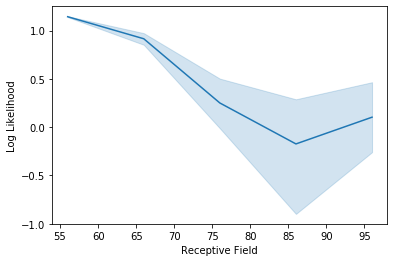

In [89]:
sns.lineplot(x="Receptive Field", y="Log Likelihood", data=df)